# CS224N Assignment 1: Exploring Word Vectors (25 Points)

# Import

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

In [2]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /home/quantran/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


# Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., Here, you will explore two types of word vectors: 
- those derived from *co-occurrence matrices*, 
- and those derived via *GloVe*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that **similar words, i.e., (near) synonyms, will be used in similar contexts**. By **examining these contexts, we can try to develop embeddings for our words**. 

With this intuition in mind, many **"old school" approaches to constructing word vectors relied on word counts**. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

**IMPORTANT**: This reduced-dimensionality co-occurrence representation **preserves semantic relationships between words**, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

(If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.)

### PROS, CONS AND TIPS OF CO-OCCURENCE

Pros:
- unlike treating words individualy like bag of words, words co-occurrence matrix is computed simply by counting how many times two words in a given window (aka context) occur together => **preserves the semantic relationship between similar words, e.g. man and woman are closer together than man and apple since they are often used in the same context => similar count regarding to their neighbor words**
- You can also apply SVD or truncated SVD just like TF-IDF

Cons: 
- need big memory to store the matrix (before SVD) since it's essentially a **sparse matrix** with **exponential size** vocab x vocab
- stop words are too frequent and have more impact on syntax => solution: set max count, log scale, or filter out stop words

Tips:
- Choose smaller windows so closer words are more significant
- Use pearson correlation (how???) instead of counts
- IMPORTANT: With **careful constructed way to build co-occurence matrix, the resulted word vectors can have semantic patterns similar to w2v word vectors**: can represent word analogy through linearity property, such as king-man+woman = queen

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [3]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [4]:
reuters_corpus = read_corpus()

In [5]:
reuters_corpus[0][:8],reuters_corpus[0][-8:]

(['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy'],
 ['(', '21', 'pct', '),', 'they', 'noted', '.', '<END>'])

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [6]:
a=[[1,2,1],[1,2,3]]


In [7]:
sorted(list(set([i for l in a for i in l])))

[1, 2, 3]

In [8]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    
    # ------------------
    # Write your implementation here.
    corpus_words = sorted(list(set([w for l in corpus for w in l])))
    # ------------------

    return corpus_words, len(corpus_words)

In [9]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [10]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    word2Ind = {v:k for k,v in enumerate(words)}
    word2Ind['#TEMP#'] = num_words # remove this entry later for a valid word2Ind
    M = np.zeros((num_words,num_words+1))
    for doc in corpus:
        # padding
        words = ['#TEMP#']*window_size + doc + ['#TEMP#']*window_size
        
        for i in range(window_size,len(doc)+window_size):
            i_row = word2Ind[words[i]]
            for j in range(i-window_size,i+window_size+1):
                i_col = word2Ind[words[j]]
                M[i_row][i_col]+=1
            M[i_row][i_row]-=1
    # remove last column of M
    M = np.delete(M,-1,1)
    del word2Ind['#TEMP#']
    # ------------------
    
    return M, word2Ind

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

In [12]:
# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2Ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

In [13]:
# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [11]:
from sklearn.decomposition import TruncatedSVD

In [12]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(k,n_iter = n_iters,random_state = 42)
    M_reduced =  svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [16]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [5]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    plotted = M_reduced[[word2Ind[w] for w in words]]
    x,y = plotted[:,0],plotted[:,1]
    fig, ax = plt.subplots()
    ax.scatter(x, y, marker='x', color='red')
    for i, txt in enumerate(words):
        ax.annotate(txt, (x[i], y[i]))

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


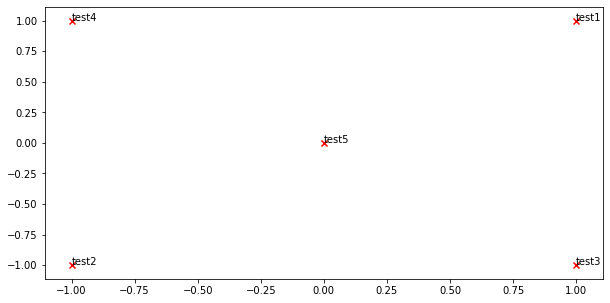

In [18]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will 
- compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. 
- Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. 
- TruncatedSVD returns U\*S, **so we need to normalize the returned vectors FOR PLOTTING PURPOSES**, so that all the vectors will appear around the unit circle** (therefore 'closeness' can be directional ). 

The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

In [19]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

Running Truncated SVD over 8185 words...
Done.


In [53]:
M_co_occurrence.shape,M_reduced_co_occurrence.shape

((8185, 8185), (8185, 2))

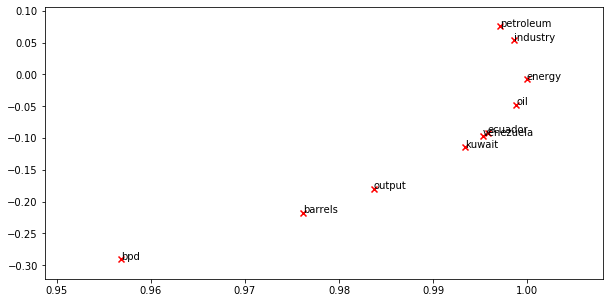

In [48]:


# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # normalize by broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
# petroleum ~ oil ~ barrels/bpd ~ energy ~ industry. Ecuador ~ kuwait ~ venezuela
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

- The 3 countries are together
- barrels and oil/petroleum are not
- top right corner kinda make sense I guess

### try TFIDF and SVD/truncated SVD/NMF for word embedding

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [63]:
temp2 = [' '.join([w.lower() for w in list(reuters.words(f))]) for f in reuters.fileids("crude")]

In [64]:
tfidf = TfidfVectorizer(stop_words='english')
tf_mat = tfidf.fit_transform(temp2) # (documents, vocab)

In [65]:
tf_mat.shape

(578, 7840)

#### truncated SVD

In [67]:
tf_reduced = reduce_to_k_dim(tf_mat.T, k=2)

Running Truncated SVD over 7840 words...
Done.


In [68]:
len(tfidf.get_feature_names())

7840

In [72]:
tf_reduced.shape

(7840, 2)

In [70]:
word2Ind_tfidf = {v:k for k,v in enumerate(tfidf.get_feature_names())}

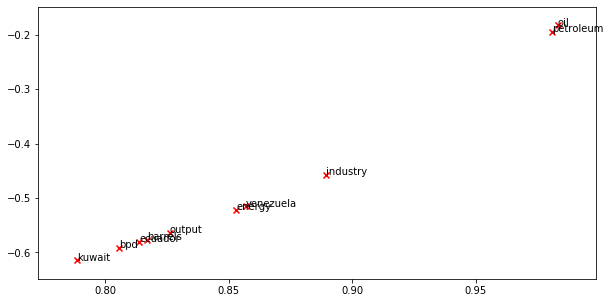

In [74]:
tf_len = np.linalg.norm(tf_reduced, axis=1)
tf_normalized = tf_reduced / tf_len[:, np.newaxis] # normalize by broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(tf_normalized, word2Ind_tfidf, words)

Note that this is document-based embeddings. 
- Oil and petroleum are together
- Countries are not
- Does not make much sense overall

#### NMF

In [75]:
from sklearn import decomposition

In [76]:
clf = decomposition.NMF(n_components=2, random_state=1)

In [77]:
W1 = clf.fit_transform(tf_mat)
H1 = clf.components_ # topic vs vocab

In [78]:
W1.shape

(578, 2)

In [79]:
H1.shape

(2, 7840)

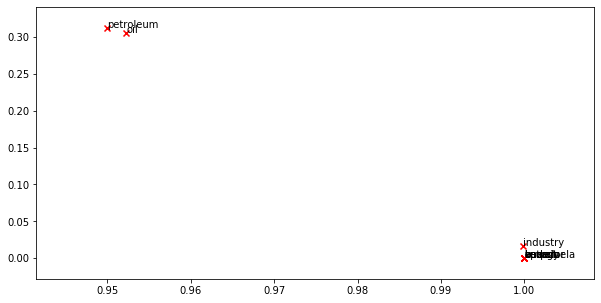

In [81]:
tf_len = np.linalg.norm(H1.T, axis=1)
tf_normalized = H1.T / tf_len[:, np.newaxis] # normalize by broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(tf_normalized, word2Ind_tfidf, words)

Interesting...

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).


### GLOVE: combining the ideas of co-occurence count matrix and neural network method.

Main idea: ratio of 2 co-occurence probabilities can encode **linear meaning components in a word vector space**

By setting dot products equal to log of co-occurence probability, this can happen

![](./imgs/Selection_028.png)

Note: left side (wa-wb) is the linear meaning (can add/subtract), right side is the (log) ratio of 2 probabilities

![](./imgs/Selection_029.png)

We try to make wiT @ w\~j and log(Xij) similar to each other, so the difference between them will be the loss. bi and b~j are bias terms (when some words are too common and more than likely to co-occur)

the f(Xij) function is to cap very common word pairs which can affect performance of the model

In [6]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [4]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [7]:
words = list(wv_from_bin.vocab.keys())
len(words)

400000

In [8]:
words[:5]

['the', ',', '.', 'of', 'to']

In [9]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w)) # word string to vector
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words: #also include words in required_words
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [13]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


In [18]:
M.shape

(10010, 200)

In [14]:
M_reduced_normalized.shape

(10010, 2)

### Question 2.1: GloVe Plot Analysis [written] (4 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

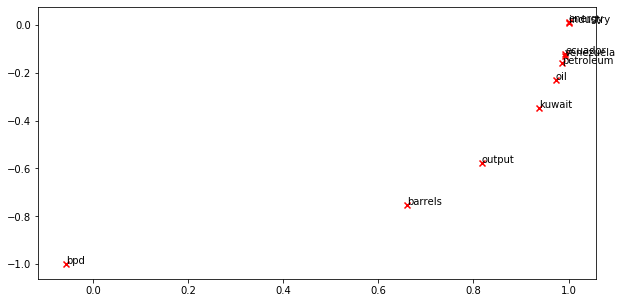

In [14]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)

- Oil and petroleum are closer (compared to co-occurence mat)
- kuwait is further from other 2 countries
- energy ~ industry

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (2 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). 

Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. 

For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [16]:
wv_from_bin.most_similar('ice')

[('hockey', 0.604852557182312),
 ('melting', 0.5738586783409119),
 ('cream', 0.5460361242294312),
 ('skating', 0.5343074798583984),
 ('floes', 0.5328742861747742),
 ('snow', 0.5312869548797607),
 ('frozen', 0.5263079404830933),
 ('winter', 0.5162127017974854),
 ('rinks', 0.5115762948989868),
 ('rink', 0.5039594173431396)]

In [17]:
wv_from_bin.most_similar('men')

[('women', 0.8027716279029846),
 ('man', 0.6218826770782471),
 ('soldiers', 0.6119741797447205),
 ('four', 0.6025701761245728),
 ('who', 0.601909875869751),
 ('others', 0.6016640663146973),
 ('they', 0.5993191003799438),
 ('young', 0.5958107113838196),
 ('boys', 0.5924804210662842),
 ('took', 0.5851980447769165)]

**Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?**: maybe it depends on the categories of corpus it trains from. With lack of information about a second meaning of a word, word2vec/glove won't be able to pick it up.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [18]:
w1 = "happy"
w2 = "cheerful"
w3 = "sad"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms happy, cheerful have cosine distance: 0.5172466933727264
Antonyms happy, sad have cosine distance: 0.40401363372802734


In [19]:
wv_from_bin.most_similar('men')

[('women', 0.8027716279029846),
 ('man', 0.6218826770782471),
 ('soldiers', 0.6119741797447205),
 ('four', 0.6025701761245728),
 ('who', 0.601909875869751),
 ('others', 0.6016640663146973),
 ('they', 0.5993191003799438),
 ('young', 0.5958107113838196),
 ('boys', 0.5924804210662842),
 ('took', 0.5851980447769165)]

The same reason to why women and men are closer together than men and man: the context where they tend to appear together. Just because two words have complete opposite meaning doesn't mean they aren't allow in the same context. Word2vec/Glove is not calculated on the basis of synonym/acronym

### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. YES, SOMETIMES, NOT ALL THE TIME!

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are **most similar/closest** to the words in the `positive` list and **most dissimilar/furthest** from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [15]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052172660828),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


In [17]:
wv_from_bin.most_similar(positive=['woman', 'king'])

[('mother', 0.717806875705719),
 ('man', 0.7114682197570801),
 ('queen', 0.6746002435684204),
 ('father', 0.6699029803276062),
 ('daughter', 0.6666619777679443),
 ('husband', 0.6582999229431152),
 ('wife', 0.6576738953590393),
 ('her', 0.6521750688552856),
 ('she', 0.649080753326416),
 ('son', 0.6373396515846252)]

In [23]:
wv_from_bin.similar_by_vector(wv_from_bin.word_vec('king') - wv_from_bin.word_vec('man'))
# meaning of kingship without the manness

[('king', 0.6220162510871887),
 ('jeongjo', 0.5617712736129761),
 ('seongjong', 0.5423533916473389),
 ('vajiravudh', 0.5373874306678772),
 ('seonjo', 0.519416093826294),
 ('taejong', 0.5177606344223022),
 ('injo', 0.514464259147644),
 ('bagyidaw', 0.5124008655548096),
 ('kalākaua', 0.5123972296714783),
 ('alveda', 0.5079326629638672)]

In [24]:
wv_from_bin.similar_by_vector(wv_from_bin.word_vec('king') - wv_from_bin.word_vec('man') + wv_from_bin.word_vec('woman'))

[('king', 0.8209067583084106),
 ('queen', 0.7119165658950806),
 ('princess', 0.6121214628219604),
 ('monarch', 0.6024806499481201),
 ('prince', 0.596004068851471),
 ('throne', 0.5915313959121704),
 ('daughter', 0.5588055849075317),
 ('elizabeth', 0.554740309715271),
 ('kingdom', 0.5494517087936401),
 ('mother', 0.5419816970825195)]

Another examples

In [25]:
pprint.pprint(wv_from_bin.most_similar(positive=['china', 'vietnamese'], negative=['vietnam']))

[('chinese', 0.8808660507202148),
 ('beijing', 0.6723365783691406),
 ('taiwanese', 0.6554437875747681),
 ('mainland', 0.6267528533935547),
 ('li', 0.61803138256073),
 ('wang', 0.603748083114624),
 ('zhu', 0.5768657326698303),
 ('wu', 0.5707286596298218),
 ('zhang', 0.5691275596618652),
 ('taiwan', 0.5678080320358276)]


In [30]:
wv_from_bin.similar_by_vector(wv_from_bin.word_vec('vietnamese') - wv_from_bin.word_vec('vietnam'))

[('french-canadian', 0.41807258129119873),
 ('niuean', 0.41111814975738525),
 ('yemenite', 0.3961483836174011),
 ('ukranian', 0.3950352072715759),
 ('dagestani', 0.39487698674201965),
 ('shaykhs', 0.3919771909713745),
 ('creole', 0.3896016776561737),
 ('vietnamese', 0.3874216675758362),
 ('romanichal', 0.38616299629211426),
 ('gilbertese', 0.3840707540512085)]

In [27]:
wv_from_bin.similar_by_vector(wv_from_bin.word_vec('vietnamese') - wv_from_bin.word_vec('vietnam')+ wv_from_bin.word_vec('china'))

[('chinese', 0.8953746557235718),
 ('china', 0.7677565813064575),
 ('beijing', 0.6976702809333801),
 ('taiwanese', 0.6600586175918579),
 ('mainland', 0.6446439623832703),
 ('vietnamese', 0.6418699026107788),
 ('li', 0.6319595575332642),
 ('wang', 0.6148654222488403),
 ('taiwan', 0.5951897501945496),
 ('zhu', 0.5861659646034241)]

In [28]:
pprint.pprint(wv_from_bin.most_similar(positive=['france', 'beer'], negative=['australia']))

[('champagne', 0.5522081851959229),
 ('wine', 0.5233477354049683),
 ('french', 0.5211446285247803),
 ('drinks', 0.5134167671203613),
 ('drink', 0.5113363265991211),
 ('cognac', 0.5102250576019287),
 ('whiskey', 0.49817317724227905),
 ('bourbon', 0.4954427182674408),
 ('perfume', 0.47533366084098816),
 ('bottle', 0.4676624536514282)]


In [29]:
wv_from_bin.similar_by_vector(wv_from_bin.word_vec('beer') - wv_from_bin.word_vec('australia'))

[('beer', 0.6559044122695923),
 ('kegs', 0.5348634719848633),
 ('whiskey', 0.5143569707870483),
 ('partagas', 0.48708200454711914),
 ('swigging', 0.4845068156719208),
 ('vodka', 0.48340117931365967),
 ('sodas', 0.4706902503967285),
 ('kolsch', 0.47039157152175903),
 ('drink', 0.46139878034591675),
 ('coolers', 0.460589736700058)]

Note: this is what these words look like on vector space. You can easily notice the linearly parallel between man/woman and king/queen or sir/madam. This is a way to evaluate your word vectors called **intrinsic evaluation**

TODO: read more about word vector evaluation, intrinsic and extrinsic evaluation: https://youtu.be/kEMJRjEdNzM?t=3450


![](./imgs/Selection_030.png)

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [37]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'manager'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'manager'], negative=['woman']))

[('assistant', 0.5620710253715515),
 ('managers', 0.5032732486724854),
 ('director', 0.49716031551361084),
 ('employee', 0.494746595621109),
 ('management', 0.48427969217300415),
 ('managing', 0.48158782720565796),
 ('spokeswoman', 0.4637411832809448),
 ('owner', 0.4630720615386963),
 ('consultant', 0.4613330364227295),
 ('wife', 0.45983457565307617)]

[('boss', 0.5852170586585999),
 ('managing', 0.5517551898956299),
 ('coach', 0.534744918346405),
 ('management', 0.5272275805473328),
 ('rangers', 0.508195698261261),
 ('team', 0.5004690885543823),
 ('owner', 0.49456924200057983),
 ('director', 0.4739380478858948),
 ('managers', 0.4705745279788971),
 ('dave', 0.4699687361717224)]


Man to manager is woman to assistant, but when the opposite to applied, man is now boss, managing ...

# Co-occurence vs skipgram/neural net approach

Co-occurence (count-based)
- Pros: fast training, use stats
- Cons: primarily to capture word similarity, some words can have large counts => disproportion in word importance

Skipgram:
- Pros: improve performance (compared to co-occurence), and can capture complex patterns (not just similarity)
- Cons: scales with corpus size (?) and don't use much stats